# Web Intelligence
# Data & Web Mining

#### Prof. Claudio Lucchese

## Problem statement

Suppose we are interested in finding documents similar to a query document. One basic approach, is to represent documents a the set of (distinct) words they contain and then rely on Jaccard similarity.

This is a common problem in several application scenarios:
 - finding near-duplicate/mirror pages in the Web
 - clustering similar news
 - finding similar users/items for recommendation, e.g., movies.

By focusing on a document (text) -based scenario, we want to achieve the following goals:
 - efficiency in time and space
 - beyond string matching
 
In terms of efficiency, dealing with raw strings would be too expensive and little practical. It is clear we need a mapping from words to numerical identifiers (ids). Equality operations (are two words the same?), search operations (is this term in that document?), and many other, are clearly more efficient and less memory demanding if every word is replaced by a simple id.

In addition, we would like to overcome the limitation of a naïve string matching. For instance, given the two documents containing "Players are ready for the next match" and "Player is ready for the next matches" , we would like to measure an high similarity between them. Unfortunately, they have only four words in common, and remaining words are identical up to their suffix.

## $k$-shingles

$k$-shingles is a (syntactic based) method to achieve the two goals above.

Consider a document as a string a characters, then it's $k$-shingles are defined as the set of substring of length $k$ occurring in the document.

**Example.** Given the document "Players are ready for the next match", its 3-shingles are defined as {"Pla", "lay", "aye", "yer", "ers", "rs ", "s a", " ar", "are", "re ", "e r", " re", "rea", "ead", "ady", "dy ", "y f", " fo", "for", "or ", "r t", " th", "the", "he ", "e n", " ne", "nex", "ext", "xt ", "t m", " ma", "mat", "atc", "tch", "che", "hes"}.

The similarity between two documents, can thus be computed as the Jaccard among their shingles.

The benefit of using shingle is given by the partial string matching they achieve. In the previous sample, the two words "Player" and "Players" will contribute to the document similarity significantly as they share some shingles. Therefore, the use of shingles provides some improvement over the simple string matching at the word level.

The length $k$ of the shingles should be decided on the basis of the document collection at hand. Low values of $k$, increase the probability of finding a shingle in a document, and therefore increase their measured similarity. Larger values of $k$ increase the discriminative power of the different shingles. Typically, a value between 5 (short documents) and 9 (long documents) is considered a good option.

The value $k$ also impact on the number of possible shingles, and therefore on their representation. In general, with an alphabet of 27 characters (26 + 1 whitespace) there are $27^k$ shingles. But not all shingles exist in the real world and not all of them are found in a document collection. A good approximation is $20^k$ shingles. Note that $20^7<2^{32}$ and $20^9\ll 2^{64}$, which allows for 32-bit and 64-bit representation. Such representation might be achieved through an explicit enumeration and mapping (i.e., the list of shingles in the full collection of document is materialized so as to assign an id to each of them), or by simply hashing a shingle into a bistring of length 32 or 64 (and discarding collisions). The latter approach is much more practical, e.g., consider adding a new document to the collection.

Finally, the number of shingles for a given document $d$ is at most given by $|d|-k+1$, where $|d|$ is the length of the document in characters. This still makes the document representation manageable regardless of $k$.


**Other ways to define shingles**. In some contexts, shingles are defined on the basis of words rather than characters as we did. The choice truly depends on the data collection at hand, and which of the two options better model the document similarity. As an additional example, a strategy that was proven to work well with news similarity search, is to define shingles as the a sequence of words occurring after a stop-word (the rationale is that stop-words introduce relevant concepts).

## Min-Hashing

Even if shingles provide some additional quality beyond a simple string matching, they are still too expansive.

**Example**. Consider a collection of 10 billion document, each with an average length of 100 words. This would results in $10\cdot 10^9 \cdot 100 \cdot 64$ bits of data, i.e., $\approx 8,000$ GB of memory. Is it feasible to scan through such volume of data for finding a similar document?

We therefore introduce a *signature* strategy, named **Min-hashing** to compact significantly the representation of a single document, still providing similarity search support.

Let's consider a document $A$ as the sets of its $k$-shingles. The min-hash of $A$ is defined as the smallest element of set $A$ after a random permutation $\pi$ is applied. Therefore, the min-hash signature of $A$ consists in single element of the set which is randomly chosen by $\pi$. We collect the min-hash signature of each document in our collection by applying the same permutation.

Suppose we have two documents/sets $A=\{a,d\}$ and $B=\{b,d,e\}$. We can represent them as a binary presence matrix:
$$
\begin{array}{ccc}
 & A & B \\ \hline
a & 1 & 0 \\
b & 0 & 1 \\
c & 0 & 0 \\
d & 1 & 1 \\
e & 0 & 1 \\
\end{array}
$$
We call $\pi$ a given random permutation of the elements in the sets, i.e., of the row of the above matrix, thus obtaining a new matrix. Note that the permutation must be global and identical for every set, and this is achieved by the row permutation.
$$
\begin{array}{ccc}
\pi & A & B \\ \hline
c & 0 & 0 \\
d & 1 & 1 \\
b & 0 & 1 \\
e & 0 & 1 \\
a & 1 & 0 \\
\end{array}
$$
The min-hash is given by the first entry equal to 1 in the above matrix. Therefore, the min-hash of $A$ is $d$ and, similarity, the min-hash of $B$ is $d$.

We denote the $min(\pi_A)$, and $min(\pi_B)$ the min-hashes of the two documents $A$ and $B$.

What we just achieved is a very compact signature, as storing one shingle is trivially much cheaper that storing the full document. But how this signature can be used for similarity search?

Let's first answer the question "what is the probability that $min(\pi_A) = min(\pi_B)$?".
To compute the min-hash of those document, we should traverse the above matrix representation from top to bottom (i.e., in the permutation order) and pick the first row with a 1. We denote with $x$ the number of rows where both documents have a 1, and with $y$ the number of rows where *only one* of the two documents has a 1. We can discard rows where both $A$ and $B$ are zeros. Therefore, of $min(\pi_A) = min(\pi_B)$ depends on the probability of getting an $x$ row before any other $y$ row. Therefore, this probability is equal to $x/(x+y)$. Another way to see this is to consider the min-hash (as we do not really care about the full permutation) as a random selection of one among the $x$ or $y$ rows; then two documents will have the same min-hash if an $x$ row is selected, for which we have a probability of $x/(x+y)$.

Let's now compute the Jaccard similarity between $A$ and $B$ in the above matrix. The Jaccard, $J(A,B)= |A\cap B|/|A\cup B|$, is given by the number of rows being all one, divided by the number of rows with at least a 1. Therefore $J(A,B)=x/(x+y)$.

We can conclude that: 
$$P\big(min(\pi_A) = min(\pi_B)\big) = J(A,B).$$


### Min-hash signatures

We have that the min-hash signature is a good signature for similarity, but still, we cannot rely on the min-hash only. If for two document we have the same min-hash we cannot conclude that they are similar, or at least we cannot tell how much.

To overcome this limitation, we can exploit multiple min-hashes. Suppose we define a set of $m$ permutations $\pi^1,\pi^2, \pi^3, \ldots$, and for each document $A$ we compute the $m$ min-hashes of such permutations $[min(\pi^1_A),min(\pi^2_A),min(\pi^3_A),\ldots]$. Such vector of permutations is named min-hash signature.

The min-hash signature can be used to provide an estimate of the similarity between two documents.
If we denote with $k$ the number of matching min-hashes out of $m$ permutations for two documents $A$ and $B$, then $J(A,B)\approx k/m$. (Law of large numbers, think about tossing a coin.) Of course we count the number of matches $k$ in the same position, i.e., generated by the same permutation. Permutations must be independent.

How many permutations should we use? Usually, we want to explore a trade-off between the accuracy, which increases with the number of permutations, and the cost of computing, processing and storing them. In general we want $m$ to be significantly smaller then the average number of terms in a document.

For the actual computation of min-hash signatures of a document, it is not needed to actually materialize a permutation of its elements. A set of hash functions is defined $h_1, \ldots, h_m$, then for each element $a \in A$ the hash $h_1$ is computed and the minimum value is then selected, and so for the other hash function $h_i$.

## LSH: Locality Sensitive Hashing for  Jaccard Distance

Even with min-hash signatures, solving the problem of finding the documents being most similar to a query document would be too expensive, as we cannot afford to scan the full list of signatures.

We need a method that allows for a faster search and selection. We can use the min-hashing signature technique to define a sort of hashing function such that two similar documents have the same hash with high probability. Therefore, given a query document, we can use the hash function to find the most similar document to that by simply accessing a look-up table.

To do so, we first split the $m$ min-hashes in $b$ bands of $r=m/b$ min-hashes each. Then, each sub-sequence of $r$ min-hashes is concatenated and hashed again so as to obtain a new hash that we call super-signature (sometimes called *super-shingle*). In this way, we have $b$ new signatures out of the initial $m$ min-hashes. Such $b$ super-signatures are used as key to access an hash-table. This means that we store the given document in an hash-table using the new signature as the key. Also, we use $b$ different hash tables for managing independently the $b$ different signatures, therefore storing the document $b$ times in total.
We know that two similar documents have probability depending on their Jaccard similarity to have the same min-hash signatures and therefore to have the same key in the hash table.

The search algorithm works as follows. Given a new document, we compute the min-hashes and its $b$ super-signatures. We use the super-signatures to access the hash-tables and to retrieve the documents associated to the its super-signatures, and, finally, the union of such documents is returned. Additionally, it would be possible to access the textual or shingle-based representation of such documents to actually compute the Jaccard similarity and filter out the *false positives* (this filtering is expensive but limited to a possibly small set of candidates).

### Analysis of LSH

The questions we should answer now, is "what is the quality of the returned documents?", "How $m$, $b$, and $r$ impact on such quality?"

To do so, we go through the following considerations.

Suppose the actual Jaccard similarity between two documents is $s$, Then:
 - the probability of having the same super-signature (super-shingle) is $s^r$
 - the probability of not having the same super-signature is $1-s^r$
 - the probability of not matching any of the $b$ super-signatures is $(1-s^r)^b$
 - The probability of matching in at least one super-signature, i.e., the probability of being retrieved, is $1-(1-s^r)^b$


The value of $r$ impacts on the *precision*, i.e., the number of *false positives* with the same super-signature.

The value of $b$ impacts on the *recall*, i.e., increases the probability of finding similar documents.

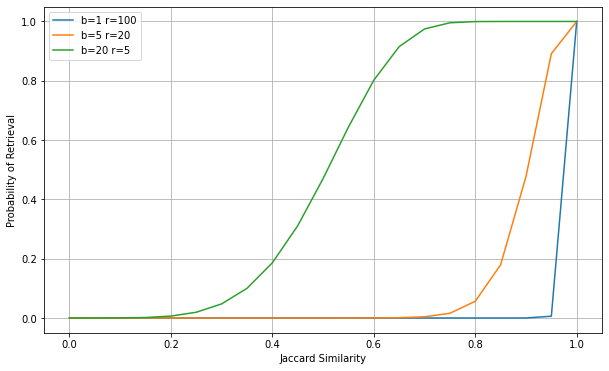

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0,1,21)

plt.figure(figsize=(10,6))

b = 1
r = 100
y = 1.0-(1.0-x**r)**b
plt.plot(x,y, label="b="+str(b)+" r="+str(r))

b = 5
r = 20
y = 1.0-(1.0-x**r)**b
plt.plot(x,y, label="b="+str(b)+" r="+str(r))

b = 20
r = 5
y = 1.0-(1.0-x**r)**b
plt.plot(x,y, label="b="+str(b)+" r="+str(r))

plt.legend()
plt.grid()
plt.xlabel("Jaccard Similarity")
plt.ylabel("Probability of Retrieval")
plt.show()

## Locality-sensitive hashing for cosine distance

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


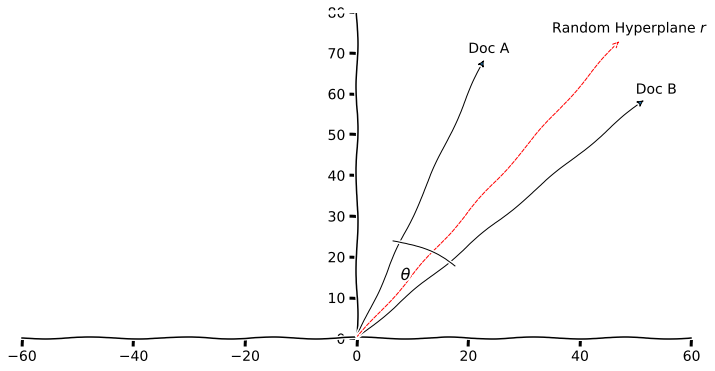

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import numpy as np
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,6))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.set_ylim([0, 80])
    ax.set_xlim([-60, 60])
    ax.annotate('Doc A', xy=(0, 0), arrowprops=dict(arrowstyle='<|-'), xytext=(20, 70))
    ax.annotate('Doc B', xy=(0, 0), arrowprops=dict(arrowstyle='<|-'), xytext=(50, 60))
    ax.annotate('Random Hyperplane $r$', xy=(0, 0), arrowprops=dict(arrowstyle='<-', color='r',ls='--'), xytext=(35, 75))
    ax.add_patch(Arc((0,0), 50, 50, 0, 45, 75, color='k', zorder=100))
    fig.text( 0.57, 0.26, '$\\theta$', ha='center', fontsize=16)

### Sim-Hashing


Consider the figure above where we have two documents $A$ and $B$ in a two dimensional vector space. The two vector-documents are separated by an angle $\theta$.

Now, let's take a random vector $r$ (hyperplane if you are in an higher dimensional space). What is the probability for $A$ and $B$ to fall on the opposite sides of $r$?

A random vector $r$ can be chosen so as to have any angle uniformly at random in the interval $[0,180]$ degrees:
 - there is $\theta/180$ probability for $r$ to fall in between the two documents, and
 - there is $(180-\theta)/180$ probability that the two documents fall on the same side of $r$

**Sim-Hashing**. The hyperplane $r$ identifies a **single bit signature** for a given document as follows:
 - signature of doc $A$ is 1 if doc $A$ is above $r$ and 0 otherwise.

The probability of two documents having the same signatures (being on the same side of $r$) is $(180-\theta)/180$, where $\theta$ is the angle between the two. 

Therefore, the sim-hashing signature can be used to estimate the cosine similarity of two documents. 


Specifically, we call **sketches** the following strategy:
 - To simplify the sampling of a random hyperplanes, just pick $r$ as a sequence of $+1$,$-1$ drawn uniformly at random.
 - Given a document $A$, compute the dot product $r\cdot A$ (similar as checking on which side of the hyperplane $A$ is). 
 - If this is positive then the signature is 1 otherwise it is 0.
 - Repeat $m$ times to compute a signature of $m$ bits.
 - Given two documents, compute the hamming distance between their signatures to estimate their angle and therefore its cosine similarity.


# References 

 - **Mining of Massive Datasets**. Leskovec, Rajaraman, Ullman. Cambridge University Press. 2014.
   - Sections 3.2, 3.3, 3.4, 3.7.2, 3.7.3

- Google News Personalization: Scalable Online Collaborative Filtering https://dl.acm.org/doi/pdf/10.1145/1242572.1242610